# <center>  Deep Neural Network (DNN) using plain TensorFlow

## <font color = 'blue'> Get the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time

%store -r
%store

Stored variables and their in-db values:
X_16_val                  -> array([[ -9.06753457e-01,   1.09156381e+00,  -5.53
X_32_val                  -> array([[ 0.08277393,  0.0713877 ,  0.88800461, ...
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[ 0.0827739
X_32train_std             -> array([[-0.00841265, -0.52374295,  0.47420127, ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[ -7.53179
X_test_std                -> defaultdict(<class 'list'>, {0: array([[-0.9067534
X_train                   -> array([[[  6.31860690e-03,   3.69167514e-03,   2.7
X_train_std               -> array([[ -8.41264958e-03,  -5.23742949e-01,   4.74
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_16_val                  -> array([2, 6, 3, ..., 2, 2, 7])
y_32_test                 -> defaultdict(<class 'list'>, {0: array([7, 4, 0, ..
y_32_train                -> array([6, 2, 4, ..., 5, 2, 7])
y_32_val                  -> array([7, 

In [2]:
print("Training data: ", X_train_std.shape, "and labels: ", y_train.shape)
print(" ")
print("Test data:")
print("Total", len(X_test_std), X_test_std[18].shape, "arrays for SNR values:")
print(sorted(X_test_std.keys()))

Training data:  (80000, 16) and labels:  (80000,)
 
Test data:
Total 20 (4000, 16) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [3]:
# tf.reset_default_graph()

## <font color='blue'> Create validation set required for early stopping

In [4]:
X_val = []
y_val = []

X_test_new = defaultdict(list)
y_test_new = defaultdict(list)

for snr in snrs:
    n_test = X_test_std[snr].shape[0]
    X_val.append(X_test_std[snr][:(n_test*0.5)])
    y_val.append(y_test[snr][:(n_test*0.5)])
    X_test_new[snr] = X_test_std[snr][(n_test*0.5):]
    y_test_new[snr] = y_test[snr][(n_test*0.5):]
    
X_val = np.vstack(np.asarray(X_val))
y_val =np.hstack(np.asarray(y_val))

print("Validation set data", X_val.shape, "and labels", y_val.shape)

X_test_std = X_test_new
y_test = y_test_new

Validation set data (40000, 16) and labels (40000,)


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## <font color = 'blue'> Design and train the DNN

In [5]:
# ----------------- Initialize parameters -----------------------


n_hidden1 = 16
n_hidden2 = 16
n_outputs = 8

X = tf.placeholder(tf.float32, shape=(None, 16))

y = tf.placeholder(tf.int64, shape=(None))

# ------------------- Define layers -----------------------

from tensorflow.contrib.layers import fully_connected

def layer(X, n_neurons, activation):
    layer = fully_connected(X, n_neurons, activation_fn = activation, 
                            weights_initializer = tf.contrib.layers.variance_scaling_initializer())
    return layer

layer1 = layer(X, n_hidden1, activation = tf.nn.relu)

layer2 = layer(layer1, n_hidden2, activation = tf.nn.relu)

logits = layer(layer2, n_outputs, activation = None)

# ----------------- Specify performance measure ----------------------

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
# ------------------ Execution phase ----------------------------------    

n_epochs = 1000
batch_size = 1024
n_train = X_train_std.shape[0]
n_iter = n_train//batch_size

saver = tf.train.Saver()

min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

acc_test = defaultdict(list)

start = time()
path = "./DNN1.relu_he.ckpt"

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size) #select random samples to form mini batches   
            X_batch, y_batch = X_train_std[rand_indices], y_train[rand_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        valid_loss, acc_val = sess.run([loss, accuracy], feed_dict={X: X_val, y: y_val})
        
        # Early stopping 
        
        if valid_loss < min_loss:
            save_path = saver.save(sess, path)
            min_loss = valid_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement > max_epochs_without_improvement:
                print("** EARLY STOPPING ** ")
                break
        print("{}\tValidation loss: {:.6f}\tMinimum loss: {:.6f}\tAccuracy on validation set: {:.2f}".format(
            epoch, valid_loss, min_loss, acc_val))

print(" ")
with tf.Session() as sess:
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_test_std[snr], y: y_test[snr]})

print("Training and testing took %f minutes"%(float(time() - start)/60))

0	Validation loss: 2.021639	Minimum loss: 2.021639	Accuracy on validation set: 0.21
1	Validation loss: 1.853869	Minimum loss: 1.853869	Accuracy on validation set: 0.26
2	Validation loss: 1.756841	Minimum loss: 1.756841	Accuracy on validation set: 0.29
3	Validation loss: 1.673226	Minimum loss: 1.673226	Accuracy on validation set: 0.33
4	Validation loss: 1.619927	Minimum loss: 1.619927	Accuracy on validation set: 0.34
5	Validation loss: 1.586580	Minimum loss: 1.586580	Accuracy on validation set: 0.35
6	Validation loss: 1.558768	Minimum loss: 1.558768	Accuracy on validation set: 0.36
7	Validation loss: 1.533480	Minimum loss: 1.533480	Accuracy on validation set: 0.37
8	Validation loss: 1.510495	Minimum loss: 1.510495	Accuracy on validation set: 0.38
9	Validation loss: 1.488340	Minimum loss: 1.488340	Accuracy on validation set: 0.39
10	Validation loss: 1.467795	Minimum loss: 1.467795	Accuracy on validation set: 0.40
11	Validation loss: 1.450127	Minimum loss: 1.450127	Accuracy on validation 

## <font color = 'blue'> Test the DNN

In [7]:
for snr in snrs:
    print("DNN's test accuracy on %d dB SNR samples = "%(snr), acc_test[snr])   

DNN's test accuracy on -20 dB SNR samples =  0.1275
DNN's test accuracy on -18 dB SNR samples =  0.1355
DNN's test accuracy on -16 dB SNR samples =  0.1305
DNN's test accuracy on -14 dB SNR samples =  0.1245
DNN's test accuracy on -12 dB SNR samples =  0.142
DNN's test accuracy on -10 dB SNR samples =  0.179
DNN's test accuracy on -8 dB SNR samples =  0.285
DNN's test accuracy on -6 dB SNR samples =  0.3925
DNN's test accuracy on -4 dB SNR samples =  0.3985
DNN's test accuracy on -2 dB SNR samples =  0.45
DNN's test accuracy on 0 dB SNR samples =  0.526
DNN's test accuracy on 2 dB SNR samples =  0.637
DNN's test accuracy on 4 dB SNR samples =  0.7865
DNN's test accuracy on 6 dB SNR samples =  0.808
DNN's test accuracy on 8 dB SNR samples =  0.8115
DNN's test accuracy on 10 dB SNR samples =  0.8285
DNN's test accuracy on 12 dB SNR samples =  0.821
DNN's test accuracy on 14 dB SNR samples =  0.8245
DNN's test accuracy on 16 dB SNR samples =  0.8165
DNN's test accuracy on 18 dB SNR sample

## <font color = 'blue'> Visualize DNN's performance

In [39]:
%store -r
from collections import defaultdict
import numpy as np
acc_test = defaultdict(list,
            {-20: 0.1275,
             -18: 0.1355,
             -16: 0.1305,
             -14: 0.1245,
             -12: 0.142,
             -10: 0.17900001,
             -8: 0.285,
             -6: 0.39250001,
             -4: 0.3985,
             -2: 0.44999999,
             0: 0.52600002,
             2: 0.63700002,
             4: 0.78649998,
             6: 0.80800003,
             8: 0.81150001,
             10: 0.82849997,
             12: 0.82099998,
             14: 0.82450002,
             16: 0.81650001,
             18: 0.81800002})
acc_test = sorted(acc_test.items())
new_acc = []
for i in range(len(acc_test)):
    new_acc.append(acc_test[i][1])
acc_test = new_acc 

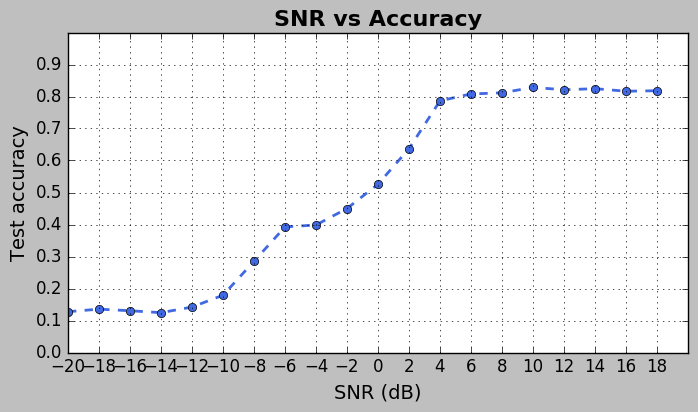

In [40]:
import matplotlib.pyplot as plt

plt.style.use('classic')

fig = plt.figure(figsize=(8, 4), dpi=100)
x = snrs
y = list(acc_test.values())
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()